In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/fotonica04/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles/')) #Current directory


###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

## Lumapi init

In [2]:
mmi = lumapi.FDTD(filename='MMI2x2.fsp',hide=False)

In [8]:
inter = lumapi.INTERCONNECT()

In [9]:
f = mmi.gdsopen('KlayoutFiles/MMITemplate.gds')

LumApiError: 'Can not open GDS file for writing.'

## Functions

In [3]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [11]:
# Body config------------------------------------
BdX_Span = 186e-6 # Body X Span
BdY_Span = 10e-6 # Body y Span


# Ports config-----------------------------------

OutMx = [3.9e-6,-3.9e-6,1.3e-6,-1.3e-6]              # Array of output ports y positions (put 0 on first element to ignore this line)
InMx = [3.9e-6,-3.9e-6,1.3e-6,-1.3e-6]               # Array of input ports y positions (put 0 on first element to ignore this line) 

# If the lines above has to be ignored, use these ones instead: 
InP = 4 # Number of Input ports
OutP = 4 # Number of Output ports
Asy = 0 # Force asymmetry on inputs ports auto-displacement (0 -> Symetry, 1 -> Asymmetry)
         
PYSpan_in = 2.4e-6 # Input Port Y Span 
PYSpan_out = 2.4e-6 # Output Port Y Span 


# Tappers config---------------------------------
SetToTappers = 1 # Set tappers as inputs/outputs
TLen = 6e-6 # Tapper Length
TWidth = 2e-6 # Tapper Width

# Bends config---------------------------------
SBended = 1 # enable S-bends on ports
SBxsp = 8e-6 # S-bend xspan
SBysp = 6e-6 # S-bend yspan


# Mesh config------------------------------------
MeshEnableIn = 1 # enable input mesh insertion
MeshEnableOut = 1 # enable output mesh insertion

MeshOver = [[0.05e-6,0.05e-6,0.1e-6] , [0.05e-6,0.05e-6,0.1e-6]] # Override mesh value dx,dy and dz ([[Input Mesh],[Output Mesh]])

## Assembly

In [19]:
# General & Body settings -----------------------------------

mmi.switchtolayout()
mmi.selectall()
mmi.delete()

TLen = TLen*SetToTappers

if InMx[0] != 0:
    InP = len(InMx)
if OutMx[0] != 0:
    OutP = len(OutMx)

RectInsert(BdX_Span/2,BdX_Span, 0,BdY_Span, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mmi)
mmi.set("name","MMI Body")

RectInsert(BdX_Span/2, BdX_Span+TLen*2+8e-6, 0, BdY_Span*1.5, -0.52e-6, 0.82e-6,
"SiO2 (Glass) - Palik",mmi)
mmi.set("name","Substrate")

# Input/Output ports setting --------------------------------

for i in range(1,InP+1):
    if(InMx[0]==0):
        InY = (i/((Asy+1)*(InP+1))-0.5)*BdY_Span*(1-2*Asy)**i
    else:
        InY = InMx[i-1]
        RectInsert(-TLen-2e-6,4e-6 , InY,0.48e-6, 0,0.22e-6,
        "Si (Silicon) - Palik",mmi)
        mmi.set("name","MMI EnterPort "+ str(i))

for i in range(1,OutP+1):
    if(OutMx[0]==0):
        OutY = (i/(OutP+1)-0.5)*BdY_Span
    else:
        OutY = OutMx[i-1]

    if(SBended==0):
        RectInsert(BdX_Span+TLen+2e-6,4e-6, OutY,0.48e-6, 0,0.22e-6,
        "Si (Silicon) - Palik",mmi)
    else:
        mmi.addobject('s_bend_wg')
        mmi.set({'x':BdX_Span+TLen, 'y':OutY, 'z':0,
                 'x span':SBxsp, 'y span':SBysp,
                 'name':"SBend OutPort "+ str(i)})
        RectInsert(BdX_Span+TLen+2e-6+SBxsp ,4e-6, OutY+SBysp ,0.48e-6, 0,0.22e-6,
        "Si (Silicon) - Palik",mmi)
    
    mmi.set("name","MMI OutPort "+ str(i))


if(SetToTappers == 1):
    for i in range(1,InP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":180,
             "x":-TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth,  
             "angle_side":90,  
             "name":"Input Taper "+ str(i)})
        InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
        mmi.set("y",InY)
  
    for i in range(1,OutP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":0,
             "x":BdX_Span+TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "angle_side":90, 
             "name":"Output Taper "+ str(i)})
        OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
        mmi.set("y",OutY)
        if(SBended==1):
             mmi.set("y",OutY-SBysp)



# FDTD setting ----------------------------------------------
mmi.addfdtd()

mmi.set({"x min":-1.3*TLen , "x max":1.3*TLen+BdX_Span,
     "y":0, "y span":1.4*BdY_Span,
     "z":0, "z span":1e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "mesh accuracy":5, "simulation time":5000e-15})


# Ports setting -----------------------------------------
mmi.selectpartial("EME::Ports::port")
mmi.delete()
for i in range(1,InP+1):
    mmi.addport()
    InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
    mmi.set({"x":-TLen*1.2, "y":InY, "y span":PYSpan_in,
    "z":0, "z span":4e-6})
 
for i in range(1,OutP+1):
    mmi.addport()
    OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
    mmi.set({"x":BdX_Span+TLen*1.2, "y":OutY, "y span":PYSpan_out,
    "z":0, "z span":4e-6})
    if(SBended==1):
        mmi.set("x",BdX_Span+TLen*1.2+SBxsp)



# Monitors setting ---------------------------------
mmi.addpower()
mmi.set({"x":BdX_Span/2, "x span":BdX_Span+1.3*TLen+4e-6, "y span":1.4*BdY_Span})
mmi.setglobalmonitor("use source limits",0)
mmi.setglobalmonitor("minimum wavelength",1500e-9)
mmi.setglobalmonitor("maximum wavelength",1600e-9)
mmi.setglobalmonitor("frequency points",15)

# Editing source settings --------------------------
mmi.select('FDTD::ports')
mmi.set('monitor frequency points',1200)
mmi.setglobalsource("wavelength start", 1500e-9)
mmi.setglobalsource("wavelength stop", 1600e-9)

    
# Mesh setting -------------------------------------
if(MeshEnableIn == 1):
    for i in range(InP):
        mmi.addmesh()
        mmi.set({"x":-2e-6-TLen/4, "x span":4e-6 + TLen/2,
                "y span":TWidth, "z":0, "z span":1e-6})
        InY = mmi.getnamed("MMI EnterPort "+ str(i+1),"y")
        mmi.set("y",InY)
        mmi.set("name","input_mesh " + str(i+1))
        mmi.set({"dx":MeshOver[0][0], "dy":MeshOver[0][1], "dz":MeshOver[0][2]})

if(MeshEnableOut == 1):
    for i in range(OutP):
        mmi.addmesh()
        mmi.set({"x":BdX_Span + 2e-6+TLen/4, "x span":4e-6 + TLen/2,
                 "y span":TWidth, "z":0, "z span":1e-6})
        OutY = mmi.getnamed("MMI OutPort "+ str(i+1),"y")
        mmi.set("y",OutY)
        if(SBended==1):
            mmi.set("y",OutY-SBysp)
        mmi.set("name","output_mesh " + str(i+1))
        mmi.set({"dx":MeshOver[1][0], "dy":MeshOver[1][1], "dz":MeshOver[1][2]}) 

## Get imbalance and excess loss

dict_keys(['lambda', 'f', 'S11', 'S14', 'S21', 'S24', 'S31', 'S34', 'S41', 'S44', 'S51', 'S54', 'S61', 'S64', 'S71', 'S74', 'S81', 'S84', 'Lumerical_dataset'])


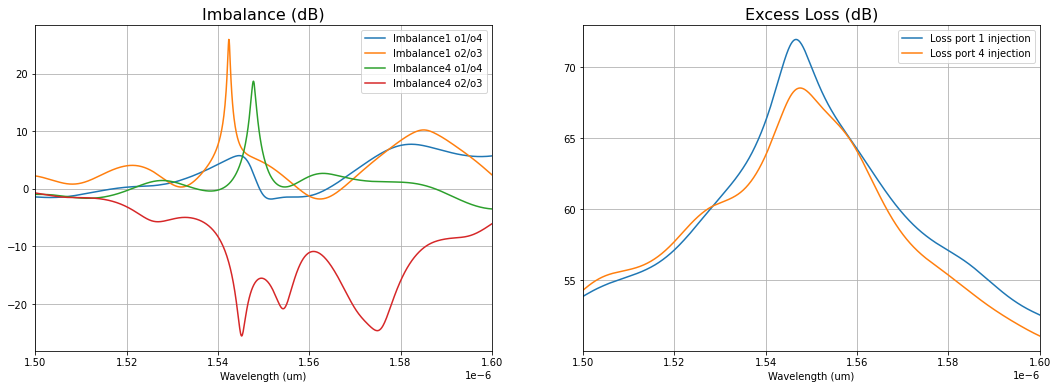

In [20]:
wavelim = [1.5e-6, 1.6e-6]

S = mmi.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort5_1 = S['S51']
SPort6_1 = S['S61']
SPort7_1 = S['S71']
SPort8_1 = S['S81']

SPort5_4 = S['S54']
SPort6_4 = S['S64']
SPort7_4 = S['S74']
SPort8_4 = S['S84']

fig, ax= plt.subplots(1,2,figsize=(18,6))
imb1_o1o4 = 10*np.log10(np.abs(SPort5_1)**2 / np.abs(SPort6_1)**2)
imb1_o2o3 = 10*np.log10(np.abs(SPort7_1)**2 / np.abs(SPort8_1)**2)
imb2_o1o4 = 10*np.log10(np.abs(SPort5_4)**2 / np.abs(SPort6_4)**2)
imb2_o2o3 = 10*np.log10(np.abs(SPort7_4)**2 / np.abs(SPort8_4)**2)
ax[0].plot(S['lambda'],imb1_o1o4, label='Imbalance1 o1/o4')
ax[0].plot(S['lambda'],imb1_o2o3, label='Imbalance1 o2/o3')
ax[0].plot(S['lambda'],imb2_o1o4, label='Imbalance4 o1/o4')
ax[0].plot(S['lambda'],imb2_o2o3, label='Imbalance4 o2/o3')
ax[0].set_title('Imbalance (dB)',fontsize=16)
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend() 

ax[1].plot(S['lambda'],-10*np.log10( ( (np.abs(SPort5_1)**2) + (np.abs(SPort6_1)**2) + (np.abs(SPort7_1)**2) + (np.abs(SPort8_1)**2) ) ), label='Loss port 1 injection')
ax[1].plot(S['lambda'],-10*np.log10( ( (np.abs(SPort5_4)**2) + (np.abs(SPort6_4)**2) + (np.abs(SPort7_4)**2) + (np.abs(SPort8_4)**2) ) ), label='Loss port 4 injection')
ax[1].set_title('Excess Loss (dB)',fontsize=16)
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
#ax[1].set_ylim(0,1)
ax[1].grid(True)
ax[1].legend()